# Set Up

In [286]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)


plt.rcParams.update({'figure.max_open_warning': 0})

# seaborn plot settings
sns.set(style="ticks", rc={'figure.figsize':(12,8)})
sns.set_palette("coolwarm")

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# Dataset Specific Set Up

In [287]:
# original fetch mldata method is not working properly - 
# import the MNIST dataset from a github repo
from six.moves import urllib
from sklearn.datasets import fetch_mldata
from scipy.io import loadmat

mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success! MNIST has been loaded.")

Success! MNIST has been loaded.


In [288]:
# set up plotting a digit
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [289]:
# set up multi-image plot
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

# Data Exploration

In [290]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [291]:
y.shape

(70000,)

A Digit Plot:


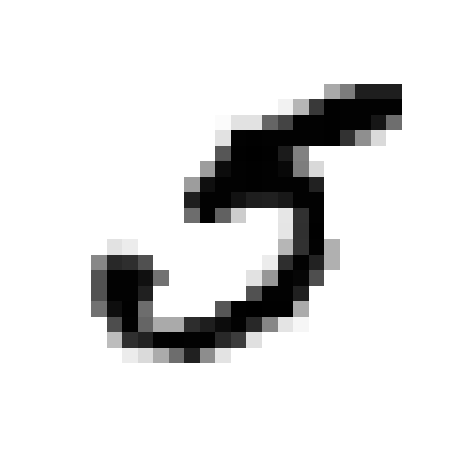

In [292]:
#inspect a random digit
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.savefig("some_digit_plot")
print("A Digit Plot:")
plt.show()

More Digits Plot:


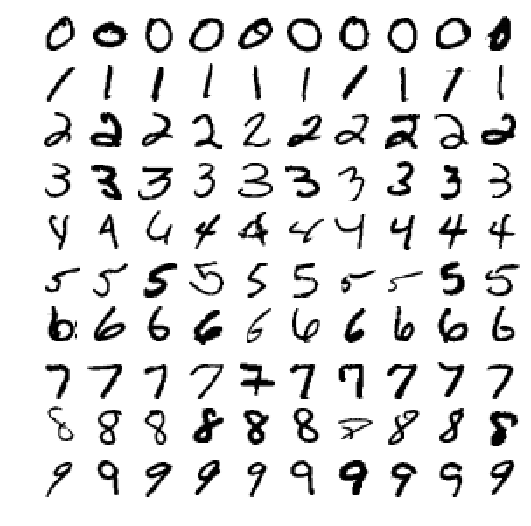

In [293]:
# further inspect random images and display it into a grid to view structure
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.savefig("more_digits_plot")
print("More Digits Plot:")
plt.show()

# Model Data Preparation

In [294]:
# utilize the first 60,000 for model development set
# utilize the final 10,000 as a holdout test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# normalize the features
# although not necessary for Random Forest, it is important for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [295]:
# view the amount of observations and explanatory variables
X_train.shape

(60000, 784)

In [296]:
# view the shape of the predictor holdout test set
y_test.shape

(10000,)

# 1. Random Forest Classifier on All Features

In [297]:
%%time

import time

# create an empty list to store time results
rf_time = []

#fit a Random Forest Classifier onto the training set
from sklearn.ensemble import RandomForestClassifier

start_time = time.clock()
rf_clf = RandomForestClassifier(max_features = 'sqrt', n_estimators=10, bootstrap=True, random_state=RANDOM_SEED)
rf_clf.fit(X_train,y_train)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
rf_time.append(runtime)

print("Success!")

Success!
Wall time: 3.44 s


In [298]:
# check runtime value
rf_time

[3.442942600000606]

In [299]:
# call the predict method onto the holdout test set
y_pred = rf_clf.predict(X_test)

In [300]:
from sklearn.metrics import classification_report

# produce a classification report
print("Random Forest Classification Report: \n{}".format(classification_report(y_test, y_pred)))

Random Forest Classification Report: 
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       980
         1.0       0.98      0.98      0.98      1135
         2.0       0.93      0.93      0.93      1032
         3.0       0.86      0.92      0.89      1010
         4.0       0.92      0.91      0.92       982
         5.0       0.83      0.92      0.87       892
         6.0       0.96      0.92      0.94       958
         7.0       0.97      0.92      0.94      1028
         8.0       0.90      0.91      0.90       974
         9.0       0.94      0.81      0.87      1009

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [301]:
# interested in just seeing performance using the F1 score
from sklearn.metrics import f1_score

scores = []

rf_f1score = f1_score(y_test, y_pred, average='weighted')
scores.append(rf_f1score)

print("F1 Score: {}".format(rf_f1score))

F1 Score: 0.9204512846222828


# 2. Principal Components Analysis - Full Set

In [302]:
%%time

# create an empty list to store time results
pca_time = []

# use PCA on all 70,000 observations
from sklearn.decomposition import PCA

start_time = time.clock()
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
pca_time.append(runtime)

print("Success!")

Success!
Wall time: 7.96 s


In [303]:
# check runtime value
pca_time

[7.956663400000252]

In [304]:
# show the reduction in features (784 to 154)
X_pca.shape

(70000, 154)

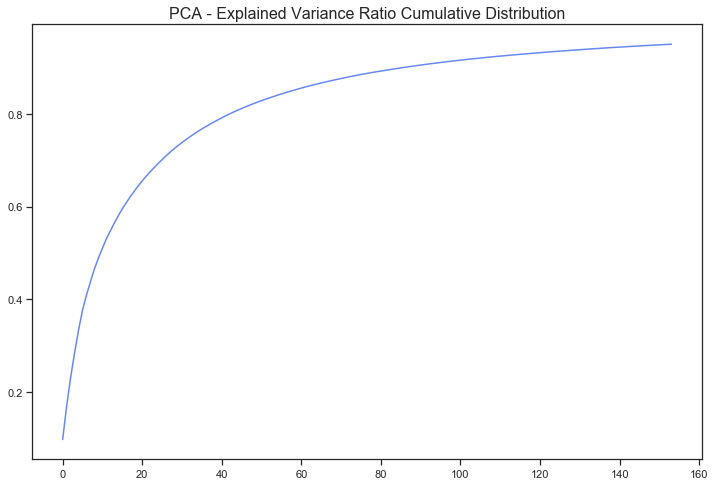

In [305]:
# PCA - Explained Variance Ratio Cumulative Distribution
var = pca.explained_variance_ratio_.cumsum()
plt.plot(var)
plt.title("PCA - Explained Variance Ratio Cumulative Distribution", fontsize=16)
plt.savefig("pca_explained_var_ratio.png")

# 3. Random Forest Classifier - Identified Principal Components

In [306]:
# set up PCA training and test sets for features
X_train_pca = X_pca[:60000]
X_test_pca = X_pca[60000:]

In [307]:
%%time

# create an empty list to store time results
rf_pca_time = []

#fit another Random Forest Classifier onto the the training set with the
# identified principal components
start_time = time.clock()
rf_clf.fit(X_train_pca,y_train)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
rf_pca_time.append(runtime)

print("Success!")

Success!
Wall time: 7.97 s


In [308]:
# check runtime value
rf_pca_time

[7.972958199999994]

In [309]:
# call the predict method onto the holdout test set
y_pred_pca = rf_clf.predict(X_test_pca)

In [310]:
# produce a classification report
print("Random Forest Classification Report: \n{}".format(classification_report(y_test, y_pred_pca)))

Random Forest Classification Report: 
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91       980
         1.0       0.97      0.98      0.97      1135
         2.0       0.87      0.90      0.88      1032
         3.0       0.83      0.89      0.86      1010
         4.0       0.86      0.90      0.88       982
         5.0       0.89      0.82      0.85       892
         6.0       0.93      0.93      0.93       958
         7.0       0.93      0.89      0.91      1028
         8.0       0.89      0.81      0.85       974
         9.0       0.89      0.84      0.86      1009

   micro avg       0.89      0.89      0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [311]:
# interested in just seeing performance using the F1 score
from sklearn.metrics import f1_score
rf_pca_f1score = f1_score(y_test, y_pred_pca, average='weighted')
scores.append(rf_pca_f1score)

print("F1 Score: {}".format(rf_pca_f1score))

F1 Score: 0.893051399636325


# 4. Model Comparison

In [312]:
# F1 Score Comparison
columns = ['RF', 'RF+PCA']
column = ['F1_Scores']
scores_comparison = pd.DataFrame(scores).T
scores_comparison.columns = columns
scores_comparison = scores_comparison.T
scores_comparison.columns = column
scores_comparison

,F1_Scores
RF,0.920451
RF+PCA,0.893051


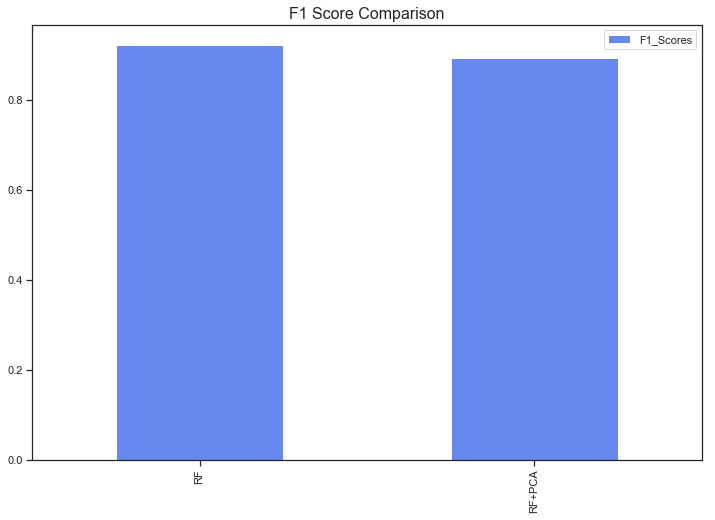

In [313]:
scores_comparison.plot(kind='bar')
plt.title("F1 Score Comparison", fontsize=16)
plt.savefig("f1_score_comparison.png")

In [314]:
# Runtime Comparison
rt_column = ['RF','PCA','RF+PCA']
rftime = pd.DataFrame(rf_time, columns=['Score'])
pcatime = pd.DataFrame(pca_time, columns=['Score'])
rf_pcatime = pd.DataFrame(rf_pca_time, columns=['Score'])

runtimes = pd.concat([rftime, pcatime, rf_pcatime])
runtimes = runtimes.T
runtimes.columns = rt_column
runtimes = runtimes.T

runtimes

,Score
RF,3.442943
PCA,7.956663
RF+PCA,7.972958


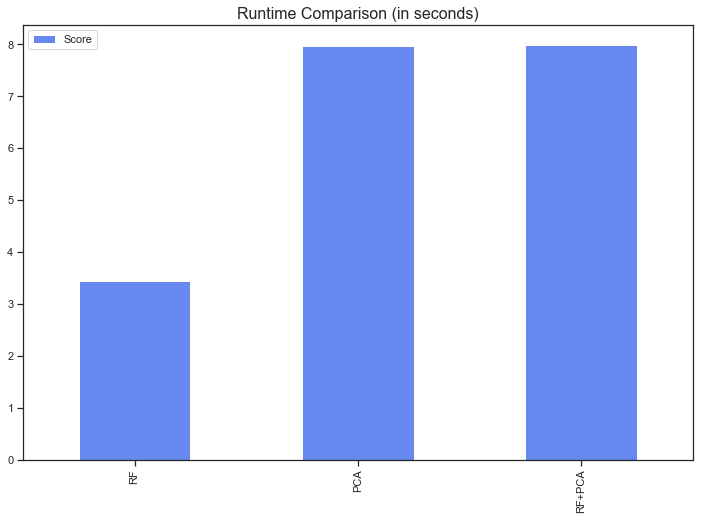

In [315]:
runtimes.plot(kind='bar')
plt.title("Runtime Comparison (in seconds)", fontsize=16)
plt.savefig("Runtime_Comparison.png")

# 5. Identify Issue and Re-run the Model

The issue is that we used PCA on the full set vs. running PCA on the train and test sets individually

In [316]:
%%time

# create an empty list to store time results
pca1_time = []

#use pca on only training
from sklearn.decomposition import PCA

start_time = time.clock()
pca = PCA(n_components = 154,random_state=RANDOM_SEED)
X_train_pca1 = pca.fit_transform(X_train)
X_test_pca1 = pca.transform(X_test)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
pca1_time.append(runtime)

print("Success!")

Success!
Wall time: 4.16 s


In [317]:
# show the reduction in features (784 to 154)
X_train_pca1.shape

(60000, 154)

In [318]:
# show the reduction in features (784 to 154)
X_test_pca1.shape

(10000, 154)

In [319]:
%%time

# create an empty list to store time results
rf_pca1_time = []

#fit another Random Forest Classifier onto the the training set with the
# identified principal components
start_time = time.clock()
rf_clf.fit(X_train_pca1,y_train)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
rf_pca1_time.append(runtime)

print("Success!")

Success!
Wall time: 7.73 s


In [320]:
# call the predict method onto the holdout test set

y_pred_pca1 = rf_clf.predict(X_test_pca1)

In [321]:
# produce a classification report
print("Random Forest Classification Report: \n{}".format(classification_report(y_test, y_pred_pca1)))

Random Forest Classification Report: 
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       980
         1.0       0.98      0.98      0.98      1135
         2.0       0.87      0.91      0.89      1032
         3.0       0.85      0.90      0.87      1010
         4.0       0.90      0.92      0.91       982
         5.0       0.89      0.86      0.88       892
         6.0       0.94      0.93      0.94       958
         7.0       0.90      0.91      0.91      1028
         8.0       0.91      0.83      0.87       974
         9.0       0.92      0.85      0.89      1009

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [325]:
# interested in just seeing performance using the F1 score
from sklearn.metrics import f1_score
rf_pca1_f1score = f1_score(y_test, y_pred_pca1, average='weighted')
scores.append(rf_pca1_f1score)

print("F1 Score: {}".format(rf_pca1_f1score))

F1 Score: 0.9070088013907918


# 6. Final Results

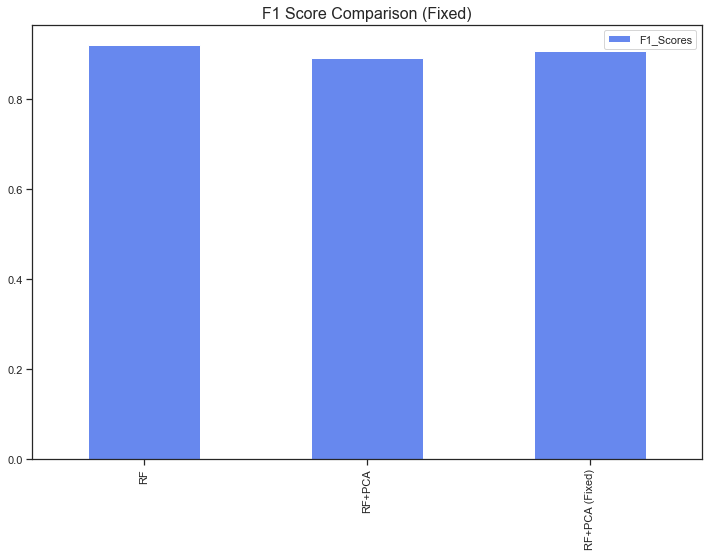

In [323]:
# F1 Score Comparison
columns = ['RF', 'RF+PCA', 'RF+PCA (Fixed)']
column = ['F1_Scores']
scores_comparison = pd.DataFrame(scores).T
scores_comparison.columns = columns
scores_comparison = scores_comparison.T
scores_comparison.columns = column
scores_comparison.plot(kind='bar')
plt.title("F1 Score Comparison (Fixed)", fontsize=16)
plt.savefig("f1_score_comparison_fixed.png")

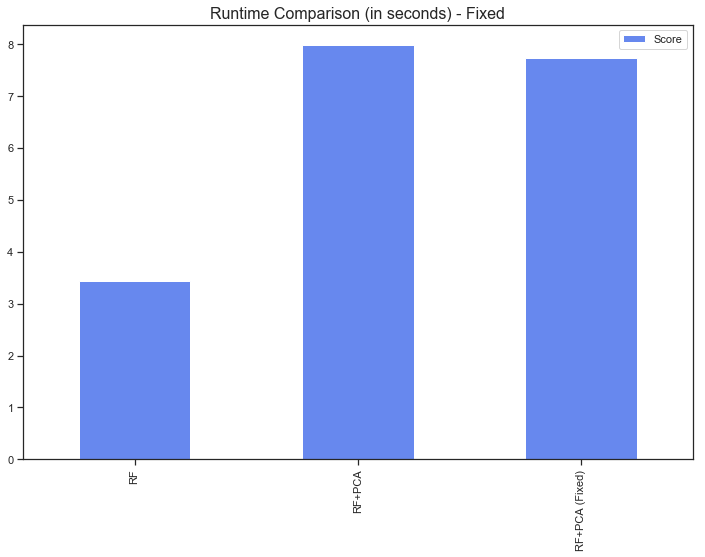

In [324]:
# Runtime Comparison
rt_column = ['RF','RF+PCA', 'RF+PCA (Fixed)']
rftime = pd.DataFrame(rf_time, columns=['Score'])
rf_pcatime = pd.DataFrame(rf_pca_time, columns=['Score'])
rf_pcatime1 = pd.DataFrame(rf_pca1_time, columns=['Score'])

runtimes = pd.concat([rftime, rf_pcatime, rf_pcatime1])
runtimes = runtimes.T
runtimes.columns = rt_column
runtimes = runtimes.T
runtimes.plot(kind='bar')
plt.title("Runtime Comparison (in seconds) - Fixed", fontsize=16)
plt.savefig("Runtime_Comparison_fixed.png")